In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
base_temperatures = pd.read_json('input_data/temperature_modis.json')
base_temperatures.sort_index(inplace=True)
temperatures = base_temperatures.copy()
base_temperatures.head()

,lst_day,lst_night
2000-02-01,282.345703,274.942841
2000-03-01,279.169983,271.005707
2000-04-01,297.531433,281.921417
2000-05-01,301.162842,284.088531
2000-06-01,303.914276,287.919983


## Time series modeling with ARIMA and SARIMAX in Python

### Data visualization and exploration

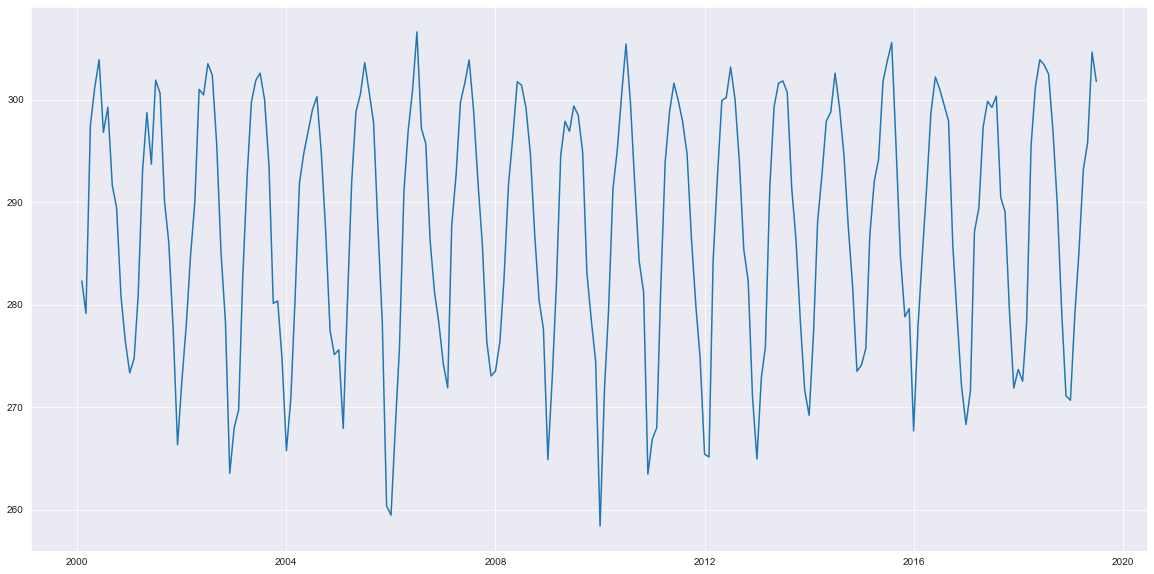

In [3]:
plt.figure(figsize=(20, 10))
ax_lineplot = sns.lineplot(data = base_temperatures['lst_day'])
plt.show()

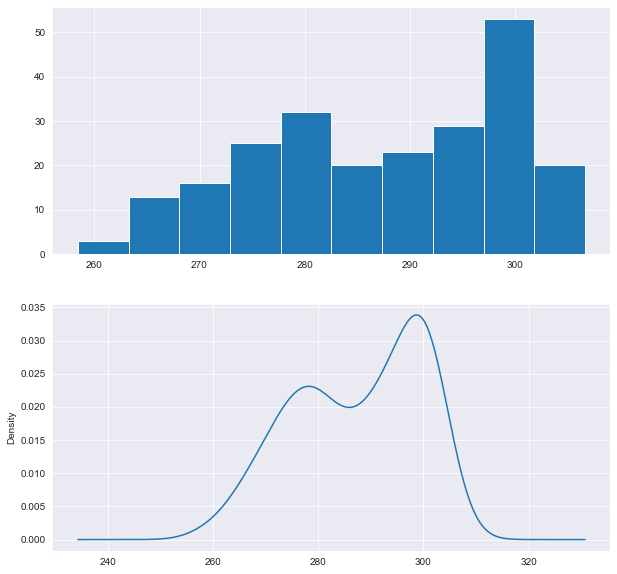

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(211)
base_temperatures['lst_day'].hist()
plt.subplot(212)
base_temperatures['lst_day'].plot(kind='kde')
plt.show()

#### Training and test sets division

In [5]:
def prepare_data_for_arima(dataset, training_size=0.8):
    """Function perform division of the dataset into training and test sets. It takes first XX% of records
    as a training set and XX is a training size, where XX is a real value between 0 and 1 provided as a 
    training_size argument."""
    
    dataset_len = len(dataset)
    print('Dataset has: {} records'.format(
    dataset_len))
    limit = int(training_size * len(dataset))
    training = dataset[:limit]
    validation = dataset[limit:]
    print('Training set has: {} records. Validation set has {} records.'.format(
    len(training), len(validation)))
    return training, validation

In [6]:
lst_day_train, lst_day_validation = prepare_data_for_arima(base_temperatures['lst_day'])

Dataset has: 234 records
Training set has: 187 records. Validation set has 47 records.


#### Test - validation error

In [7]:
def mean_abs_perc_error(predictions, validation_data):
    mape = np.mean(np.abs(predictions - validation_data)/np.abs(validation_data))
    return mape

def test_walk_forward(train_set, validation_set):
    observation = [train_set[-1]]  # The first predicted value
    predictions = []
    for i in range(len(validation_set)):
        # Prediction
        predictions.append(observation[-1])
        # Observation
        obs = validation_set[i]
        observation.append(obs)
    error_percent = mean_abs_perc_error(predictions, validation_set)
    print(error_percent)
    return error_percent

In [8]:
base_error = test_walk_forward(lst_day_train, lst_day_validation)

0.020376477901236048


### ARIMA modeling

In [9]:
# Import

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox

In [10]:
# Is time series stationary? (no)

fuller_test = adfuller(lst_day_train)
print('ADF:', fuller_test[0])
print('p-value:', fuller_test[1])
print('critical values:', fuller_test[4])

ADF: -2.765876207885162
p-value: 0.06331585206123404
critical values: {'1%': -3.4687256239864017, '5%': -2.8783961376954363, '10%': -2.57575634100705}


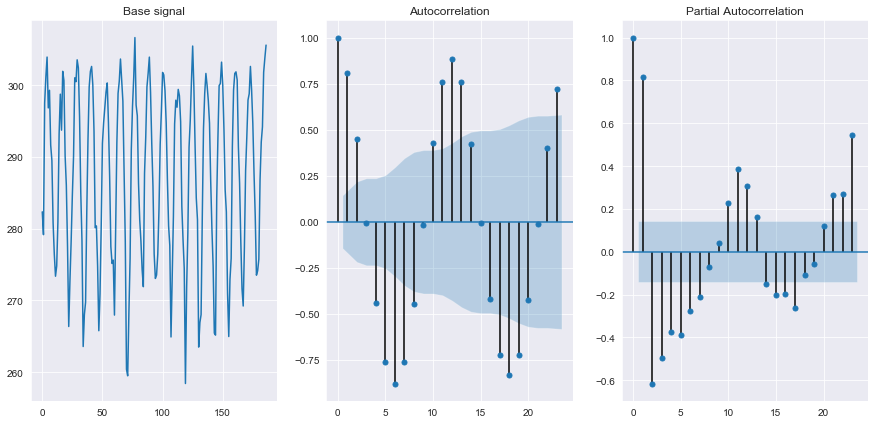

In [11]:
# Line, ACF, PACF plots of an unchanged signal

fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 7))
axes[0].plot(lst_day_train.values)
axes[0].set_title('Base signal')
plot_acf(lst_day_train.values, ax=axes[1])
plot_pacf(lst_day_train.values, ax=axes[2])
plt.show()

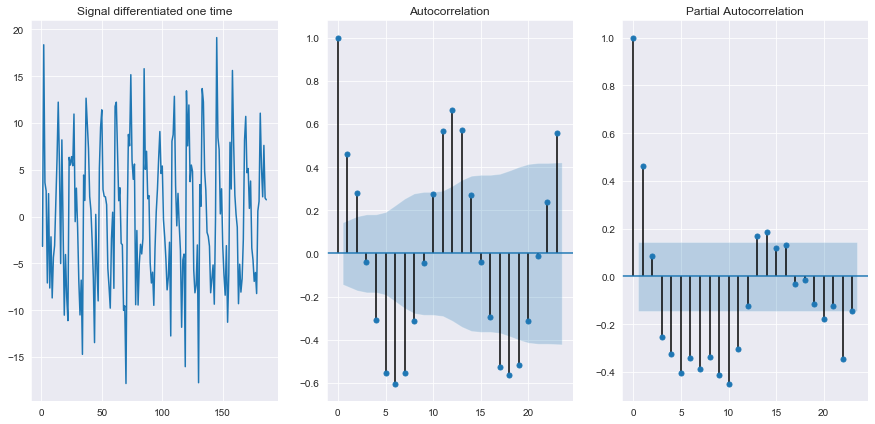

In [12]:
# 1st order differentiation

fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 7))
axes[0].plot(lst_day_train.diff().values)
axes[0].set_title('Signal differentiated one time')
plot_acf(lst_day_train.diff().dropna().values, ax=axes[1])
plot_pacf(lst_day_train.diff().dropna().values, ax=axes[2])
plt.show()

/Users/szymonmolinski/anaconda3/envs/ts_analysis/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


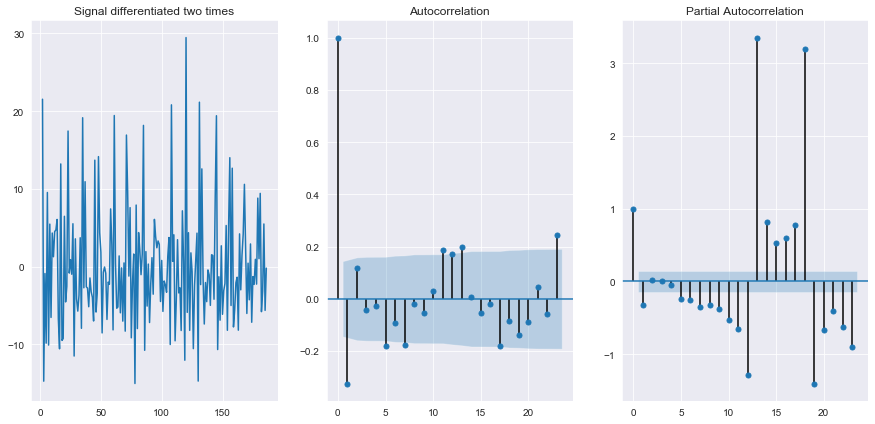

In [13]:
# 2nd order differentiation

fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 7))
axes[0].plot(lst_day_train.diff().diff().values)
axes[0].set_title('Signal differentiated two times')
plot_acf(lst_day_train.diff().diff().dropna().values, ax=axes[1])
plot_pacf(lst_day_train.diff().diff().dropna().values, ax=axes[2])
plt.show()

In [14]:
# Prediction for the model: AR = 1, I = 1, MA = 0 (p,d,q)

model = ARIMA(lst_day_train.values, order=(1, 1, 0))
model_fit = model.fit(trend='nc', disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  186
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -612.976
Method:                       css-mle   S.D. of innovations              6.527
Date:                Sat, 17 Aug 2019   AIC                           1229.951
Time:                        10:35:26   BIC                           1236.403
Sample:                             1   HQIC                          1232.566
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.4598      0.065      7.095      0.000       0.333       0.587
                                    Roots                                    
                  Real          Imaginary           M

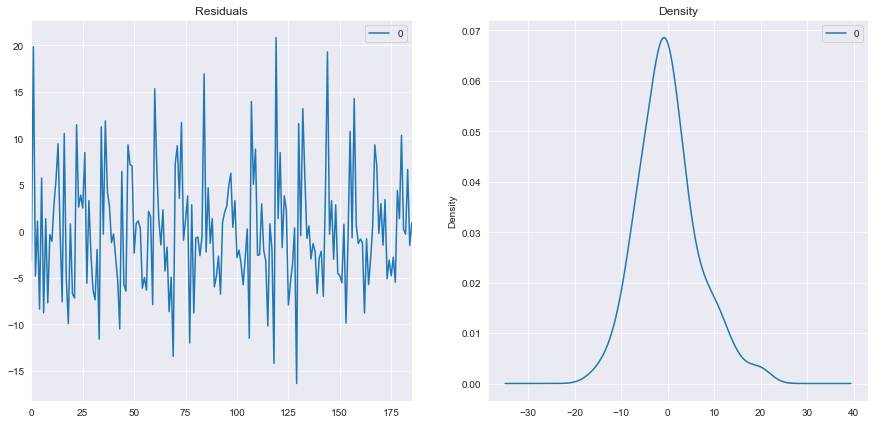

In [15]:
# Residuals

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, sharex=False, figsize=(15, 7))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

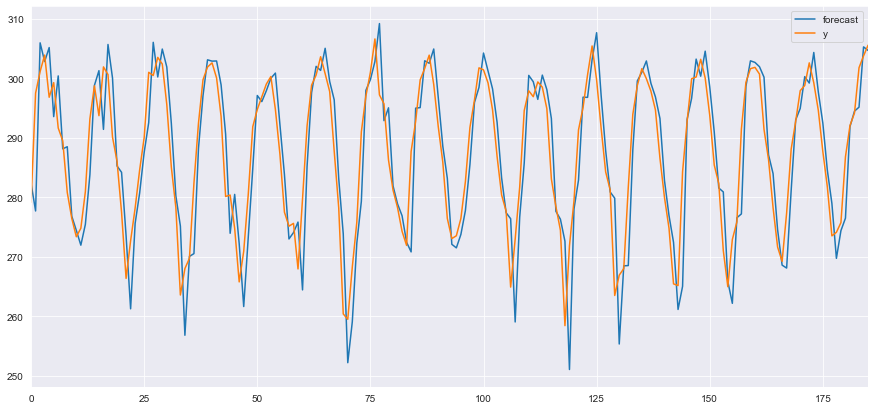

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
model_fit.plot_predict(dynamic=False, ax=ax)
plt.show()

In [18]:
# Model validation

def arima_validation(training_set, validation_set, arima_model, model_order):
    
    history = list(training_set)
    
    # first prediction
    predictions = []
    predicted = float(arima_model.forecast()[0])
    predictions.append(predicted)
    history.append(validation_set[0])
    
    # rolling forecasts
    for i in range(1, len(validation_set)):
        model = ARIMA(history, model_order)
        model_fit = model.fit(trend='nc', disp=0)
        predicted = model_fit.forecast()[0]
        predictions.append(predicted[0])
        
        # observation
        obs = validation_set[i]
        history.append(obs)
        print('>> Predicted = {:.1f}, Expected = {:.1f}'.format(predicted[0], obs))
    return predictions

forecasts = arima_validation(lst_day_train.values, lst_day_validation.values, model_fit, (1, 1, 0))
error_value = mean_abs_perc_error(forecasts, lst_day_validation.values)

print('Error value is:', error_value)

>> Predicted = 290.5, Expected = 284.7
>> Predicted = 279.8, Expected = 278.8
>> Predicted = 276.1, Expected = 279.6
>> Predicted = 280.0, Expected = 267.7
>> Predicted = 262.2, Expected = 278.0
>> Predicted = 282.5, Expected = 284.7
>> Predicted = 287.7, Expected = 291.5
>> Predicted = 294.5, Expected = 298.7
>> Predicted = 302.0, Expected = 302.2
>> Predicted = 303.8, Expected = 301.1
>> Predicted = 300.5, Expected = 299.5
>> Predicted = 298.8, Expected = 298.0
>> Predicted = 297.3, Expected = 285.7
>> Predicted = 280.2, Expected = 278.6
>> Predicted = 275.3, Expected = 272.0
>> Predicted = 269.1, Expected = 268.3
>> Predicted = 266.6, Expected = 271.6
>> Predicted = 273.1, Expected = 287.1
>> Predicted = 294.2, Expected = 289.5
>> Predicted = 290.5, Expected = 297.4
>> Predicted = 301.0, Expected = 299.9
>> Predicted = 301.0, Expected = 299.3
>> Predicted = 299.0, Expected = 300.4
>> Predicted = 300.9, Expected = 290.5
>> Predicted = 286.0, Expected = 289.1
>> Predicted = 288.5, Exp

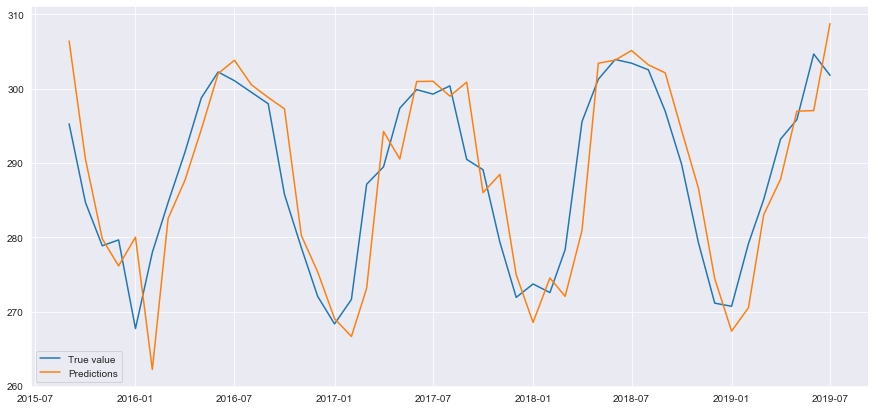

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plt.plot(lst_day_validation.index, lst_day_validation.values)
plt.plot(lst_day_validation.index, forecasts)
plt.legend(['True value', 'Predictions'])
plt.show()

In [20]:
# SARIMAX model

model = SARIMAX(lst_day_train.values, order=(1, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(trend='nc', disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  187
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -488.546
Date:                            Sat, 17 Aug 2019   AIC                            985.093
Time:                                    10:37:09   BIC                            997.729
Sample:                                         0   HQIC                           990.219
                                            - 187                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4483      0.071     -6.301      0.000      -0.588      -0.309
ar.S.L12      -0.0511      0.079   

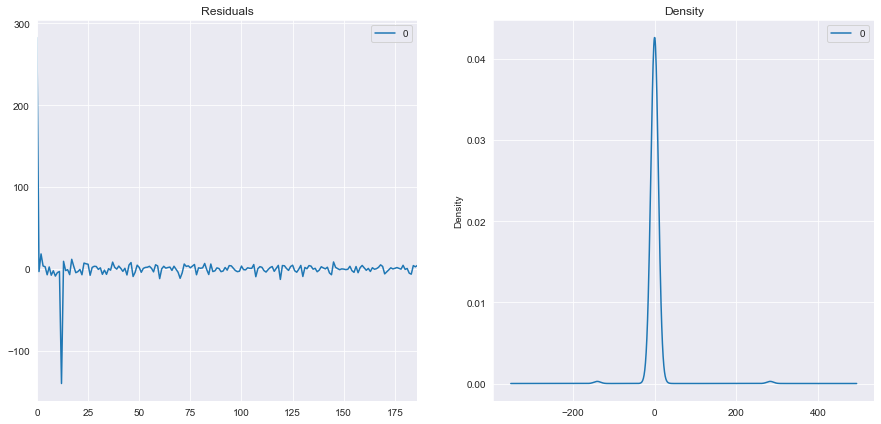

In [21]:
# Residuals

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, sharex=False, figsize=(15, 7))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [22]:
# SARIMAX validation

def sarima_validation(training_set, validation_set, sarima_model, model_order, seasonal_order):
    
    history = list(training_set)
    
    # first prediction
    predictions = []
    predicted = float(sarima_model.forecast()[0])
    predictions.append(predicted)
    history.append(validation_set[0])
    
    # rolling forecasts
    for i in range(1, len(validation_set)):
        model = SARIMAX(history, order=model_order, seasonal_order=seasonal_order)
        model_fit = model.fit(trend='nc', disp=0)
        predicted = model_fit.forecast()[0]
        predictions.append(predicted)
        
        # observation
        obs = validation_set[i]
        history.append(obs)
        print('>> Predicted = {:.1f}, Expected = {:.1f}'.format(predicted, obs))
    return predictions

forecasts = sarima_validation(lst_day_train.values, lst_day_validation.values, model_fit,
                              (1, 1, 0), (1, 1, 1, 12))
error_value = mean_abs_perc_error(forecasts, lst_day_validation.values)

print('Error value is:', error_value)

>> Predicted = 289.3, Expected = 284.7
>> Predicted = 279.5, Expected = 278.8
>> Predicted = 270.8, Expected = 279.6
>> Predicted = 272.0, Expected = 267.7
>> Predicted = 275.8, Expected = 278.0
>> Predicted = 284.9, Expected = 284.7
>> Predicted = 296.5, Expected = 291.5
>> Predicted = 298.7, Expected = 298.7
>> Predicted = 300.1, Expected = 302.2
>> Predicted = 303.7, Expected = 301.1
>> Predicted = 300.1, Expected = 299.5
>> Predicted = 293.1, Expected = 298.0
>> Predicted = 288.0, Expected = 285.7
>> Predicted = 281.5, Expected = 278.6
>> Predicted = 271.5, Expected = 272.0
>> Predicted = 267.7, Expected = 268.3
>> Predicted = 272.7, Expected = 271.6
>> Predicted = 281.6, Expected = 287.1
>> Predicted = 294.3, Expected = 289.5
>> Predicted = 298.3, Expected = 297.4
>> Predicted = 298.9, Expected = 299.9
>> Predicted = 301.8, Expected = 299.3
>> Predicted = 298.3, Expected = 300.4
>> Predicted = 292.8, Expected = 290.5
>> Predicted = 283.8, Expected = 289.1
>> Predicted = 279.6, Exp

In [23]:
def test_walk_forward_by_period(train_set, validation_set, period=12):
    j = -period
    observation = [train_set[j]]  # The first predicted value
    predictions = []
    for i in range(len(validation_set)):
        # Prediction
        predictions.append(observation[-1])
        # Observation
        j = j + 1
        if j < 0:
            obs = train_set[j]
        else:
            obs = validation_set[i-(period-1)]
        observation.append(obs)
    error_percent = mean_abs_perc_error(predictions, validation_set)
    return error_percent

In [24]:
print('>> Seasonal base error is:', test_walk_forward_by_period(lst_day_train, lst_day_validation), '%')

>> Seasonal base error is: 0.011056509218030022 %
